In [283]:
import json
import importlib
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
import src.plots
from src.plots import plot_quant_vs_ogtt, annotate_point
from src.utils import tight_bbox

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib import patches, transforms
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import seaborn as sns 
import plotly.express as px
plt.style.use('../data/metadata/Nilerat_matplotlib_stylesheet.mplstyle')

In [2]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

In [3]:
data['signif_interaction'] = data['qval_sampling:ogtt'] < 0.05
data['signif_sampling'] = data['qval_sampling'] < 0.05
gb_means = (data
            .loc[:, data_cols]
            .groupby(fg['bg_type'], axis=1)
            .mean()
           )

data['fasted_mean'] = gb_means['FBG']
data['fed_mean'] = gb_means['RBG']
data['Log2 Fold Change'] = data['fed_mean'] - data['fasted_mean']

data['Fed - Fasted slope'] = data['coef_fed'] - data['coef_fasted']
data['signif_sampling'] = data['qval_sampling'] < 0.05
data['signif_interact'] = data['qval_sampling:ogtt'] < 0.05
data['log_qval_sampling'] = -np.log10(data['qval_sampling'])
data['log_qval_ogtt'] = -np.log10(data['qval_ogtt'])
data['log_qval_sampling:ogtt'] = -np.log10(data['qval_sampling:ogtt'])
data['is_id'] = data['superclass'] != 'Unidentified'

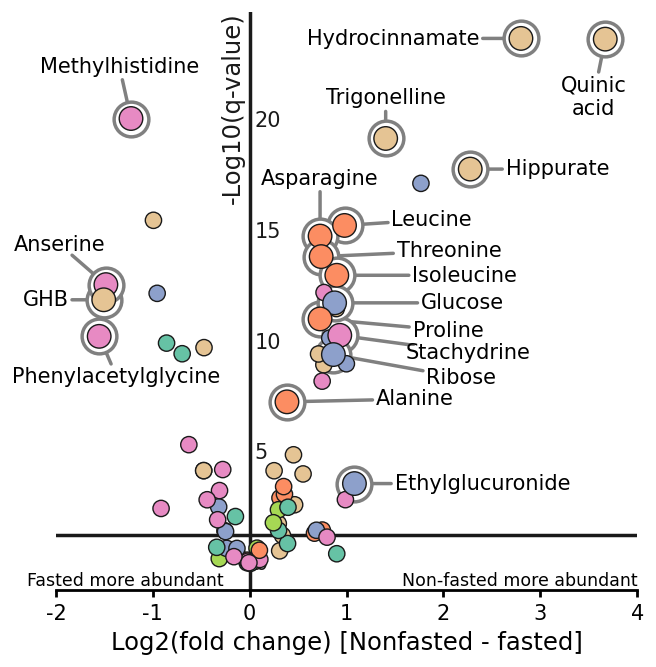

In [294]:
importlib.reload(src.plots)
outliers = {
    'm_133': dict(x=-2, y=9, t='Methylhistidine'),
    'm_136': dict(x=-10, y=0, t='GHB'),      
    'm_106': dict(x=-8, y=7, t='Anserine'),      
    'm_27' : dict(x=3, y=-7, t='Phenylacetylglycine'),   

    'm_65' : dict(x=15, y=0, t='Hippurate'),
    'm_7'  : dict(x=0, y=7, t='Trigonelline'),
    'm_61' : dict(x=-22, y=0, t='Hydrocinnamate'),
    'm_20' : dict(x=-2, y=-10, t='Quinic\nacid'),
    
    'm_54' : dict(x=15, y=1, t='Leucine'), 
    'm_103': dict(x=0, y=10, t='Asparagine'),
    'm_9'  : dict(x=22, y=1, t='Threonine'), 
    'm_58' : dict(x=22, y=0, t='Isoleucine'),
    'm_22' : dict(x=22, y=-2, t='Proline'),   
    'm_16' : dict(x=22, y=-3, t='Stachydrine'),   
    'm_19' : dict(x=22, y=-4, t='Ribose'),   
    'm_111': dict(x=22, y=0.5, t='Alanine'),   
    'm_78' : dict(x=22, y=0, t='Glucose'),   
    'm_80' : dict(x=22, y=0, t='Ethylglucuronide'),   
    }
data['outlier'] = data.index.isin(outliers)
fig, ax = plt.subplots(dpi=250, figsize=(3,3))
src.plots.volcano(
    x='Log2 Fold Change', y='log_qval_sampling', df=data.loc[data['ID'] != 'Unidentified'], 
    metab_type='metabolite', alpha=1, size='outlier', 
    ax=ax)
for i, row in data.loc[outliers].iterrows():
    xy = (row['Log2 Fold Change'], row['log_qval_sampling'])
    if 't' in outliers[i]:
        text = outliers[i]['t']
    else:
        text = row['ID']
    src.plots.annotate_point(text=text, xy=xy, xytext=(outliers[i]['x'], outliers[i]['y']), ax=ax,
                   fontsize=6, circle_size=100)

sns.despine(left=True)
plt.savefig('../reports/figures/Figure4/metabs_volcano.pdf', dpi=300, bbox_inches='tight')

# Metabolite slope_vs_slope

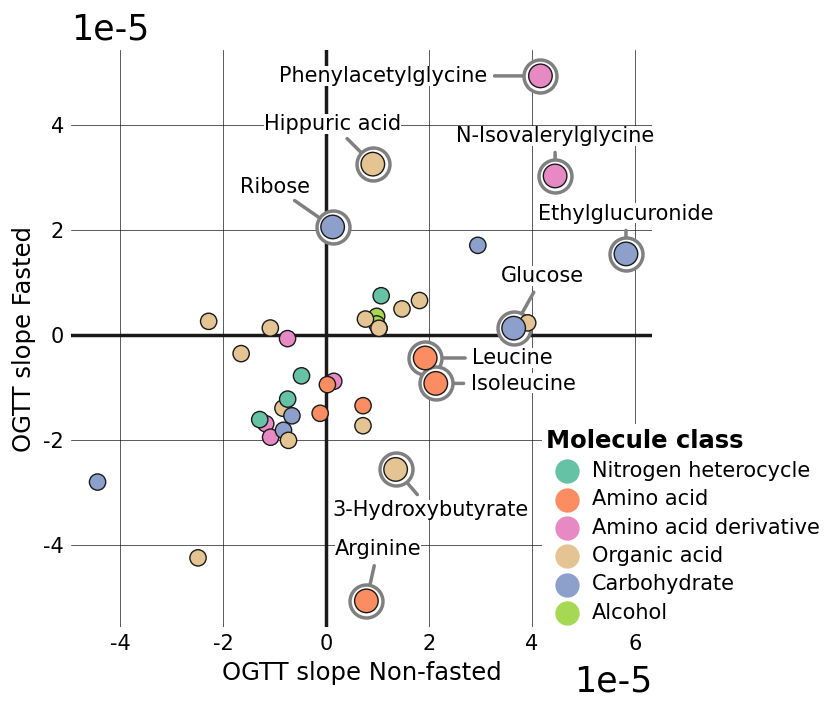

In [319]:
importlib.reload(src.plots)
df = data.loc[(data['Type'] == 'metabolite') & (data['ID'] != 'Unidentified')].copy()
df = df.loc[~(df['ID'].isin(['Anhydrohexose', 'Pentose sugar', 'Hexose sugar']))
            & ((df['qval_fasted'] < 0.1) | (df['qval_fed'] < 0.1))]
outliers = {
#     'm_4' :  dict(x=0, y=0.1),  # uric acid
    'm_27':  dict(x=-27, y=0),  #phenylacetylglycine
    'm_38':  dict(x=0, y=7),  # N-Isovalerylglycine
    'm_80':  dict(x=0, y=7, t='Ethylglucuronide'),  # Ethyl-beta-D-glucuronide
    'm_78':  dict(x=5, y=9),  # glucose
    'm_65':  dict(x=-7, y=7), # hippuric acid
#     'm_45':  dict(x=-0.065, y=-0.065), # methylhistidine
#     'm_64':  dict(x=-0.05, y=-0.05),  # His
    'm_105': dict(x=2, y=9),  # Arg
#     'm_13':  dict(x=-0.05, y=0.05), # Taurine
    'm_19':  dict(x=-10, y=7),  # Ribose
    'm_136': dict(x=6, y=-7, t='3-Hydroxybutyrate'), # 3-Hydroxybutyric acid
#     'm_72':  dict(x=0.15, y=-0.03), # guanidinosucc acid
    'm_54':  dict(x=15, y=0), # Leu 
    'm_58':  dict(x=15, y=0), # Isoleu
#     'm_120': dict(x=0.0, y=0.06), # 8-hydroxy quinoline
#     'm_144': dict(x=0.0, y=0.0), # anhydro glucitol
#     'm_20':  dict(x=-0.1, y=0.05),  # quinic acid
#     'm_81':  dict(x=0.0, y=-0.06),  # ergothioneine
#     'm_77':  dict(x=-0.15, y=0.03),  # glutamic acid
}
df['outlier'] = df.index.isin(outliers)
fig, ax = plt.subplots(dpi=250, facecolor='white', figsize=(3, 3))
src.plots.slope_vs_slope(
    df=df, x='coef_fed', y='coef_fasted', metab_type='metabolite', size='outlier', ax=ax,
    show_legend=True)
# ax.set_xticks([-4e-5, -2e-5, 0, 2e-5, 4e-5, 6e-5], [-4, -2, 0, 2, 4, 6])
# ax.set_yticks([-12e-5, -10e-5, -8e-5, -6e-5, -4e-5, -2e-5, 0, 2e-5, 4e-5, 6e-5], [-12, -10, -8, -6, -4, -2, 0, 2, 4, 6])
for i, row in data.loc[outliers].iterrows():
    xy = (row['coef_fed'], row['coef_fasted'])
    if 't' in outliers[i]:
        text = outliers[i]['t']
    else:
        text = row['ID']
    src.plots.annotate_point(
        text=text, xy=xy, xytext=(outliers[i]['x'], outliers[i]['y']), ax=ax, zorder=1)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(
    handles=handles[1:-3], labels=labels[1:-3], loc=(0.81, 0.001), 
    title='Molecule class', fontsize=6, 
    title_fontproperties=dict(size=7, weight='semibold'),  # plt.matplotlib.font_manager.FontProperties
    frameon=True, framealpha=1, facecolor='1', fancybox=False, edgecolor='none')
legend._legend_box.align = 'left'
# plt.savefig('../reports/figures/Figure4/coef_fasted_vs_fed_filtered.pdf', dpi=300, bbox_inches='tight')

In [320]:
df = data.loc[(data['superclass'] != 'Unidentified') & (data['Type'] == 'metabolite')].copy()
df['i'] = df.index
px.scatter(
    df, x='coef_fed', y='coef_fasted', color='superclass', 
#     color_discrete_map=colors,
    hover_data=['ID', 'i', 'molec_class'], )

# Lipid Volcano

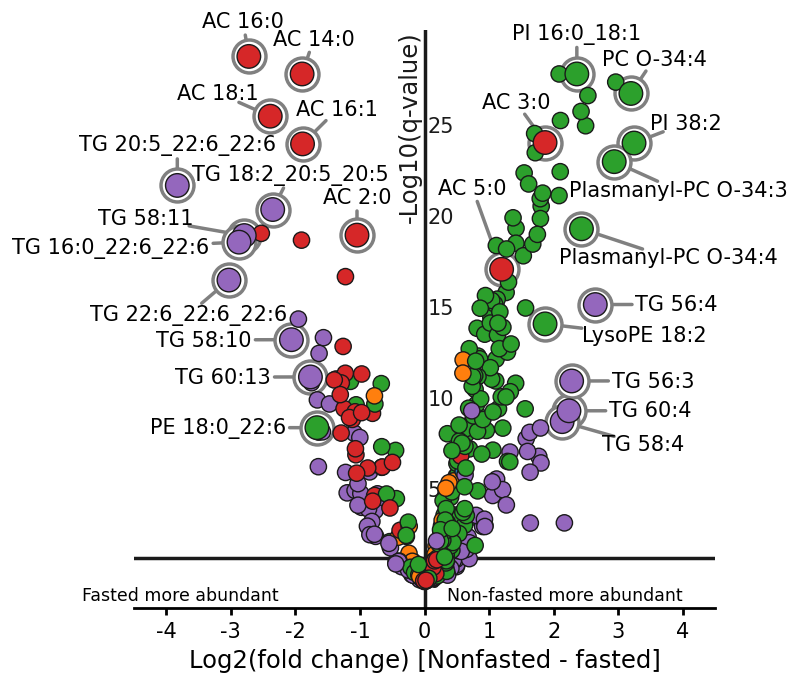

In [295]:
importlib.reload(src.plots)
outliers = {
    'l_8'  : dict(x=-1, y=6, t='AC 16:0'),
    'l_5'  : dict(x=-9, y=4, t='AC 18:1'),
    'l_10' : dict(x=2, y=6, t='AC 14:0'),
#     'l_4'  : dict(x=-0.01, y=0.15, t='AC 18:2'),
    'l_7'  : dict(x=6, y=6, t='AC 16:1'),
    'l_3'  : dict(x=0, y=6.5, t='AC 2:0'),
    'l_569': dict(x=0, y=7, t='TG 20:5_22:6_22:6'), # TG 64:17
    'l_590': dict(x=3, y=6, ), 
    'l_635': dict(x=-17, y=3, t='TG 58:11'),
    'l_652': dict(x=-22, y=-1, t='TG 16:0_22:6_22:6'),
    
    'l_582': dict(x=-7, y=-6, t='TG 22:6_22:6_22:6'), # TG 66:18
    'l_372': dict(x=-17, y=0.01, t='PE 18:0_22:6'),  # PE 40:6
#     
    'l_665': dict(x=-15, y=-0.03, t='TG 58:10'),
#     'l_603': dict(x=-0.1, y=-0.03, t='TG 60:13'),
    'l_716': dict(x=-15, y=-0.03, t='TG 60:13'),

    'l_222': dict(x=0, y=7, t='PI 16:0_18:1'),  # PI 34:1
    'l_331': dict(x=9, y=3.5, t='PI 38:2'), 
    'l_187': dict(x=4, y=6, t='PC O-34:4'),
#     'l_235': dict(x=0.2, y=-0.04, t='PC 18:2_18:2'), # PC 36:4
    'l_269': dict(x=11, y=-5, t='Plasmanyl-PC O-34:3'),
    'l_241': dict(x=15, y=-5, t='Plasmanyl-PC O-34:4'),
    
    'l_828': dict(x=14, y=0.02, t='TG 56:4'), # TG 60:4
    'l_23' : dict(x=17, y=-2, t='LysoPE 18:2'), # TG 60:4
    'l_888': dict(x=14, y=0.02, t='TG 60:4'), # TG 60:4
    'l_866': dict(x=14, y=0.02, t='TG 56:3'),
    'l_862': dict(x=14, y=-4, t='TG 58:4'), # TG 58:4
#     'l_893': dict(x=0.15, y=0.01, t='TG 18:2_18:1_22:0'), # TG 58:3
     
#     'l_828': dict(x=0.1, y=0.02, t='TG 56:4'),
#     'l_771': dict(x=0.1, y=0.02, t='TG 50:2'),
#     'l_323': dict(x=0.15, y=0.05, t='PI 18:1_18:0'),
#     'l_241': dict(x=0.05, y=0, t='Plasmanyl-PC O-34:4'),
    'l_0'  : dict(x=-5, y=14, t='AC 5:0'),
#     # 'l_1'  : dict(x=-0.1, y=0.4, t='AC 4:0'),
    'l_2'  : dict(x=-5, y=7, t='AC 3:0'),
    
}
data['outlier'] = data.index.isin(outliers)
fig, ax = plt.subplots(dpi=250, figsize=(3,3))
src.plots.volcano(
    x='Log2 Fold Change', y='log_qval_sampling', df=data.loc[data['ID'] != 'Unidentified'], 
    metab_type='lipid', alpha=1, size='outlier', 
    ax=ax)
ax.set_xlim(-4.5, 4.5)

for i, row in data.loc[outliers].iterrows():
    xy = (row['Log2 Fold Change'], row['log_qval_sampling'])
    if 't' in outliers[i]:
        text = outliers[i]['t']
    else:
        text = row['ID']
    src.plots.annotate_point(text=text, xy=xy, 
                             xytext=(outliers[i]['x'], outliers[i]['y']), ax=ax,)
plt.savefig('../reports/figures/Figure5/lipids_volcano.pdf', dpi=300, bbox_inches='tight')

In [192]:
data['i'] = data.index
df = data.loc[(data['ID'] != 'Unidentified') & (data['Type'] == 'lipid')]
px.scatter(
    df, x='Log2 Fold Change', y='log_qval_sampling', color='superclass', 
#     color_discrete_map=colors,
    hover_data=['ID', 'i', 'molec_class'], 
)

# Lipid slope_vs_slope

In [338]:
np.arange(-20, 20, 2)/(1e-5)

array([-2000000., -1800000., -1600000., -1400000., -1200000., -1000000.,
        -800000.,  -600000.,  -400000.,  -200000.,        0.,   200000.,
         400000.,   600000.,   800000.,  1000000.,  1200000.,  1400000.,
        1600000.,  1800000.])

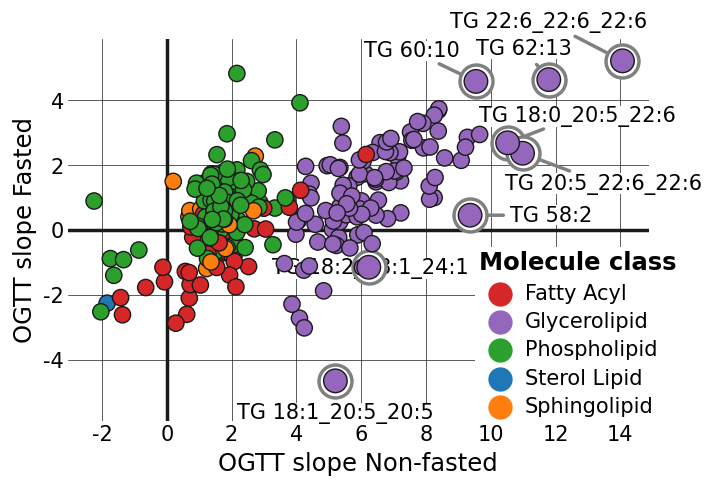

In [373]:
importlib.reload(src.plots)
df = data.loc[(data['Type'] == 'lipid') & (data['ID'] != 'Unidentified')].copy()
df = df.loc[~(df['ID'].isin(['Anhydrohexose', 'Pentose sugar', 'Hexose sugar']))
            & ((df['qval_fasted'] < 0.1) | (df['qval_fed'] < 0.1))]
outliers = {  
    'l_582': dict(x=-6, y=10, t='TG 22:6_22:6_22:6'),  # 66:18
    'l_623': dict(x=-2, y=8, t='TG 62:13'),       # 62:13
    'l_716': dict(x=-11, y=8, t='TG 60:10'),       # 60:10
    'l_680': dict(x=12, y=7, t='TG 18:0_20:5_22:6'),
    'l_569': dict(x=14, y=-8, t='TG 20:5_22:6_22:6'),  # 64:17
    
#     'l_644': dict(x=-0.05, y=0.11, t='TG 18:2_18:2_22:6'), # 58:10
    'l_910': dict(x=14, y=0, t='TG 58:2'),        # 58:2
    'l_617': dict(x=0, y=-8.5, t='TG 18:1_20:5_20:5'),  # 58:11
#     'l_888': dict(x=0.2, y=-0.2, t='TG 18:2_18:1_24:1'), # 50:4

#     'l_372': dict(x=0.11, y=-0.03, t='PE 18:0_22:6'),  # PE 40:6
#     'l_241': dict(x=-0.15, y=0.05, t='Plasmanyl-PC O-34:4'),
#     'l_404': dict(x=-0.06, y=0.08, t='PE 18:0_20:4'),    # PE 38:4

#     'l_10': dict(x=0.11, y=-0.20, t='AC 14:0'),
#     'l_4': dict(x=0.15, y=-0.15, t='AC 18:2'),
#     # 'l_1': dict(x=0.0, y=-0.25, t='AC 4:0'),

#     # 'l_32': dict(x=-0.11, y=0.10, t='LysoPC 17:1'),
#     'l_844': dict(x=-0.11, y=-0.24, t='CE 18:1'),
#     # 'l_47': dict(x=-0.10, y=0.02, t='LysoPC 18:1'),
#     'l_197': dict(x=-0.05, y=0.0, t='PC 38:7'),
#     'l_507': dict(x=-0.2, y=0.1, t='SM d41:2'),
#     'l_232': dict(x=-0.2, y=0.1, t='PC O-40:7'),
}
df['outlier'] = df.index.isin(outliers)
fig, ax = plt.subplots(dpi=250, facecolor='white', figsize=(3, 3))
src.plots.slope_vs_slope(
    df=df, x='coef_fed', y='coef_fasted', metab_type='lipid', size='outlier', ax=ax,
    show_legend=True)
ax.set_ylim(-5.9e-5, 5.9e-5)
for i, row in data.loc[outliers].iterrows():
    xy = (row['coef_fed'], row['coef_fasted'])
    if 't' in outliers[i]:
        text = outliers[i]['t']
    else:
        text = row['ID']
    src.plots.annotate_point(
        text=text, xy=xy, xytext=(outliers[i]['x'], outliers[i]['y']), ax=ax, zorder=1)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(
    handles=handles[1:-3], labels=labels[1:-3], loc=(0.7, 0.001), 
    title='Molecule class', fontsize=6, 
    title_fontproperties=dict(size=7, weight='semibold'),  # plt.matplotlib.font_manager.FontProperties
    frameon=True, framealpha=1, facecolor='1', fancybox=False, edgecolor='none')
legend._legend_box.align = 'left'
# ax.set_aspect('equal')
# plt.savefig('../reports/figures/Figure4/coef_fasted_vs_fed_filtered.pdf', dpi=300, bbox_inches='tight')

In [ ]:
df = data.loc[(data['superclass'] != 'Unidentified') & (data['Type'] == 'metabolite')].copy()
df['i'] = df.index
px.scatter(
    df, x='coef_fed', y='coef_fasted', color='superclass', 
#     color_discrete_map=colors,
    hover_data=['ID', 'i', 'molec_class'], )

# Old versions of code below
## See also `Fig4_subplots.py` and `Fig5_subplots.py` under `/src/`

<AxesSubplot:xlabel='Log2 Fold Change', ylabel='-log10(q-value)'>

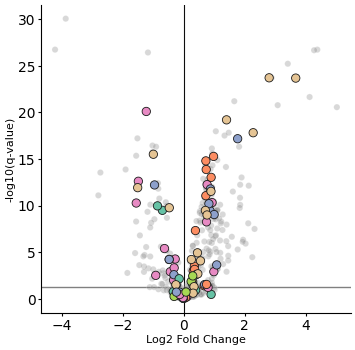

In [65]:
def volcano(x, y, df, metab_type, alpha=0.8, ax=None, legend=False, size=None, sizes=None,):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,4), dpi=100)
    sns.scatterplot(
        data=df.loc[(df['superclass'] != 'Unidentified') & (df['Type'] == metab_type)], 
        x=x, y=y, hue='superclass', palette=colors, 
        size=size, sizes=sizes,
#         s=30, linewidth=0.2, edgecolor='gray',
        edgecolor='0.1', linewidth=0.6,
        ax=ax, alpha=alpha, legend=legend)
    sns.scatterplot(
        data=df.loc[(df['superclass'] == 'Unidentified') & (df['Type'] == metab_type)], 
        x=x, y=y, hue='superclass', palette=colors, ax=ax, 
        s=20,
        alpha=0.3, zorder=-1, legend=legend)
    ax.ticklabel_format(style='sci', scilimits=(-2, 2))
    ax.set_ylabel('-log10(q-value)')
    if legend:
        ax.legend(loc=(1.01, 0.1), markerscale=1.2)
#     ax.set_title(y)
    ax.axvline(0, linewidth=0.8, c='0.05', zorder=-99)
    ax.axhline(-np.log10(0.05), linewidth=1, c='0.5', zorder=-200)
    sns.despine()
    return ax
# volcano(x='Log2 Fold Change', y='log_qval_sampling', df=data, metab_type='lipid')
volcano(x='Log2 Fold Change', y='log_qval_sampling', df=data, metab_type='metabolite', alpha=1)

<AxesSubplot:xlabel='Log2 Fold Change', ylabel='-log10(q-value)'>

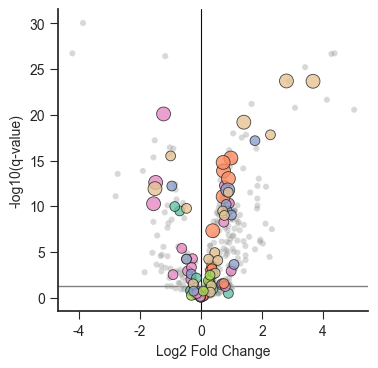

In [388]:
volcano(x='Log2 Fold Change', y='log_qval_sampling', df=data, metab_type='metabolite', size='outlier', 
        sizes={True:100, False:50})

In [49]:
data['i'] = data.index
df = data.loc[(data['ID'] != 'Unidentified') & (data['Type'] == 'lipid')]
px.scatter(
    df, x='Log2 Fold Change', y='log_qval_sampling', color='superclass', 
#     color_discrete_map=colors,
    hover_data=['ID', 'i', 'molec_class'], 
)

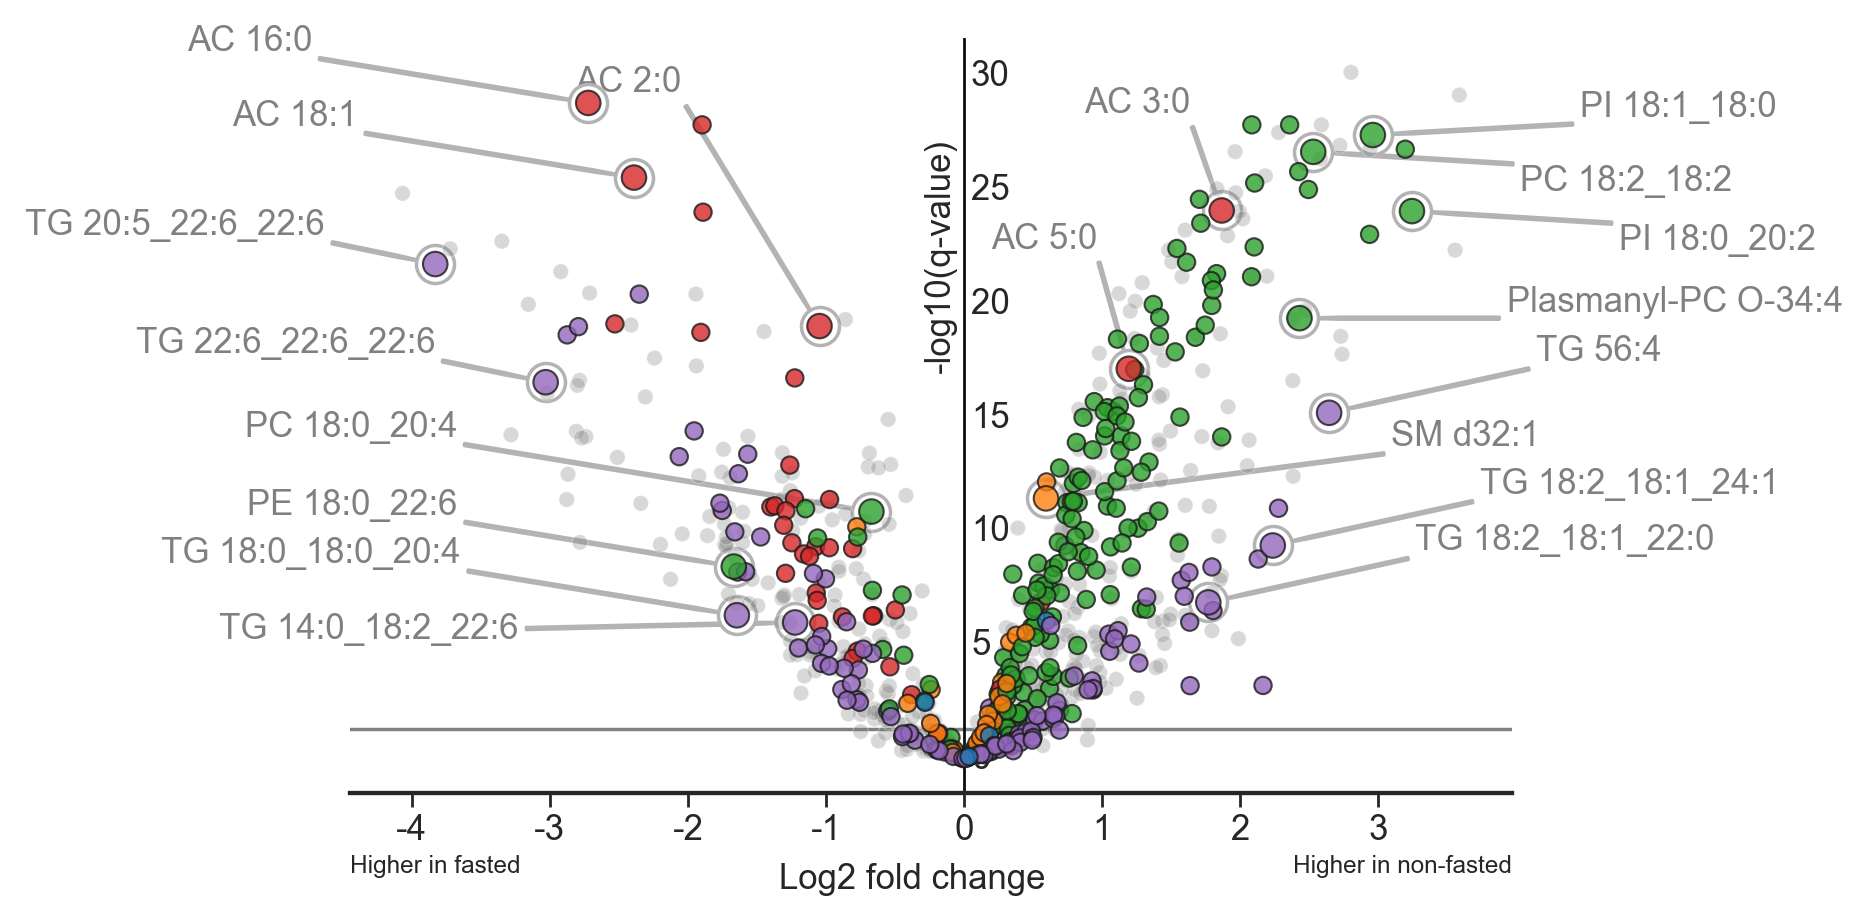

In [421]:
outliers = {
    'l_8'  : dict(x=-2, y=2),      # 'AC 16:0'
    'l_5'  : dict(x=-2, y=2),      # 'AC 18:1'
    'l_569': dict(x=-0.8, y=1),      # 'TG 20:5_22:6_22:6'
    'l_582': dict(x=-0.8, y=1),      # 'TG 22:6_22:6_22:6'
    'l_372': dict(x=-2, y=2),      # 'PE 18:0_22:6'
    'l_391': dict(x=-3, y=3),      # 'PC 18:0_20:4'
    'l_860': dict(x=-2, y=2),      # 
    'l_638': dict(x=-2, y=-1), 
    
    'l_888': dict(x=1.5, y=2),      # 'TG 18:2_18:1_24:1'
    'l_893': dict(x=1.5, y=2),      # 'TG 18:2_18:1_22:0'
    'l_323': dict(x=1.5, y=0.5),      # 'PI 18:1_18:0'
    'l_235': dict(x=1.5, y=-2),      # 'PC 18:2_18:2'
    'l_163': dict(x=2.5, y=2),      # 'SM d32:1'
    'l_241': dict(x=1.5, y=0),      # Plasmanyl-PC O-34:4
    'l_331': dict(x=1.5, y=-2),      # 
    'l_828': dict(x=1.5, y=2),      # TG 56:4
    'l_0'  : dict(x=-1, y=5),  # AC 5:0
#     'l_1'  : dict(x=-1, y=10),  # AC 4:0
    'l_2'  : dict(x=-1, y=4),  # AC 3:0
    'l_3'  : dict(x=-1, y=10),  # AC 2:0
}
data['outlier'] = data.index.isin(outliers)
data = data.sort_values('outlier')
fig, ax = plt.subplots(dpi=250, facecolor='white')
volcano(x='Log2 Fold Change', y='log_qval_sampling', df=data, metab_type='lipid', 
        size='outlier', sizes={True: 50, False: 25}, ax=ax)
for i, row in data.loc[outliers].iterrows():
    x, y = row['Log2 Fold Change'], row['log_qval_sampling']
    if x < 0:
        ha = 'right'
        xtext = x + outliers[i]['x']
    else: 
        ha = 'left'
        xtext = x + outliers[i]['x'] 
    ax.annotate(row['ID'], xy=(x, y), 
                xytext=(xtext, y+outliers[i]['y']), 
                arrowprops=dict(width=0.6, headwidth=0.6, facecolor='gray', edgecolor='0.7'),
                ha=ha, annotation_clip=False, zorder=-5, va='bottom', color='0.5',)
    ax.scatter(x, y, edgecolor='0.7', facecolor='white', linewidth=1, s=120, zorder=-4)
ax.tick_params(axis='y', length=0, )
ax.tick_params(axis='x', length=4, pad=2)
ax.set_ylabel(None)
ax.set_yticks([])
ax.set_xlabel(None)
fig.text(0.5, 0.03, 'Log2 fold change', ha='center')
ax.text(s='-log10(q-value)', x=-0.05, y=17, ha='right', va='bottom', rotation=90,)
for tick in range(0, round(ax.get_ylim()[1]), 5):
    ax.text(x=0.05, y=tick, s=tick, ha='left', va='center', zorder=-20, )

ax.text(ax.get_xlim()[0], -5, 'Higher in fasted', ha='left', fontsize=7)
ax.text(ax.get_xlim()[1], -5, 'Higher in non-fasted', ha='right', fontsize=7)
sns.despine(left=True)

In [420]:
data.loc[data['molec_class'] == 'AC'].sort_index()

,unique_id,ID,m/z,RT,molec_class,Type,polarity,lc_type,superclass,1091_8_FBG,...,fed_mean,Log2 Fold Change,Fed - Fasted slope,signif_interact,log_qval_sampling,log_qval_ogtt,log_qval_sampling:ogtt,is_id,i,outlier
i,,,,,,,,,,,,,,,,,,,,,
l_0,AC 5:0_5.964_246.17,AC 5:0,246.16996,5.964,AC,lipid,+,HILIC,Fatty Acyl,20.773834,...,22.221564,1.192264,0.000015,False,17.143519,1.256232,1.020961,True,l_0,True
l_1,AC 4:0_7.082_232.1543,AC 4:0,232.15435,7.082,AC,lipid,+,HILIC,Fatty Acyl,19.846289,...,20.299460,0.558147,0.000013,False,6.894962,5.255277,0.751310,True,l_1,True
l_10,AC 14:0_2.591_372.3107,AC 14:0,372.31069,2.591,AC,lipid,+,HILIC,Fatty Acyl,20.823548,...,18.604440,-1.897063,0.000032,True,27.865886,2.975478,3.447559,True,l_10,False
l_2,AC 3:0_7.805_218.1387,AC 3:0,218.13868,7.805,AC,lipid,+,HILIC,Fatty Acyl,20.218725,...,22.348722,1.864898,0.000006,False,24.102005,1.782040,0.248223,True,l_2,True
l_3,AC 2:0_8.718_204.1231,AC 2:0,204.12313,8.718,AC,lipid,+,HILIC,Fatty Acyl,26.515578,...,25.398966,-1.047007,0.000011,False,19.019783,3.442636,0.915940,True,l_3,True
l_4,AC 18:2_2.271_424.3421,AC 18:2,424.34207,2.271,AC,lipid,+,HILIC,Fatty Acyl,20.713250,...,18.176490,-2.528536,0.000032,False,19.117048,0.568390,1.188239,True,l_4,False
l_5,AC 18:1_2.228_426.3578,AC 18:1,426.35780,2.228,AC,lipid,+,HILIC,Fatty Acyl,22.275246,...,19.961855,-2.390245,0.000024,True,25.547163,0.329207,1.394995,True,l_5,True
l_6,AC 18:0_2.189_428.3741,AC 18:0,428.37406,2.189,AC,lipid,+,HILIC,Fatty Acyl,20.172169,...,19.053337,-1.225936,0.000027,True,16.740107,0.221007,2.226885,True,l_6,False
l_7,AC 16:1_2.419_398.3264,AC 16:1,398.32641,2.419,AC,lipid,+,HILIC,Fatty Acyl,20.335927,...,18.509605,-1.890326,0.000028,True,24.026476,0.748569,2.194242,True,l_7,False


In [271]:
data['i'] = data.index
df = data.loc[
    (data['ID'] != 'Unidentified') & 
    (data['Type'] == 'metabolite')]
px.scatter(
    df, x='Log2 Fold Change', y='log_qval_sampling', color='superclass', 
#     color_discrete_map=colors,
    hover_data=['ID', 'i', 'molec_class', 'm/z', 'RT'], 
)

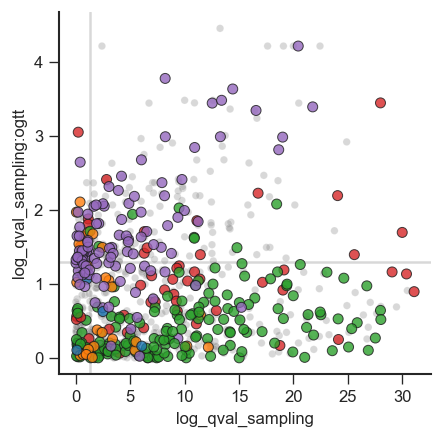

In [8]:
def pvals_plot(x, y, df, metab_type, alpha=0.8, ax=None, legend=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,4), dpi=120)
    sns.scatterplot(
        data=df.loc[(df['is_id'] == True) & (df['Type'] == metab_type)], 
        x=x, y=y, hue='superclass', palette=colors,
        edgecolor='0.1', linewidth=0.6, ax=ax, legend=legend, alpha=alpha)
    sns.scatterplot(
        data=df.loc[(df['is_id'] == False) & (df['Type'] == metab_type)], 
        x=x, y=y, hue='superclass', palette=colors, s=20, ax=ax, legend=legend, alpha=0.3, zorder=-10)
    ax.axhline(-np.log10(0.05), c='gray', alpha=0.3, zorder=-99)
    ax.axvline(-np.log10(0.05), c='gray', alpha=0.3, zorder=-99)
    if legend:
        ax.legend(loc=(1.01, 0.1), markerscale=1.2)
    sns.despine()
pvals_plot(x='log_qval_sampling', y='log_qval_sampling:ogtt', df=fc, metab_type='lipid')

# Combine all the plots

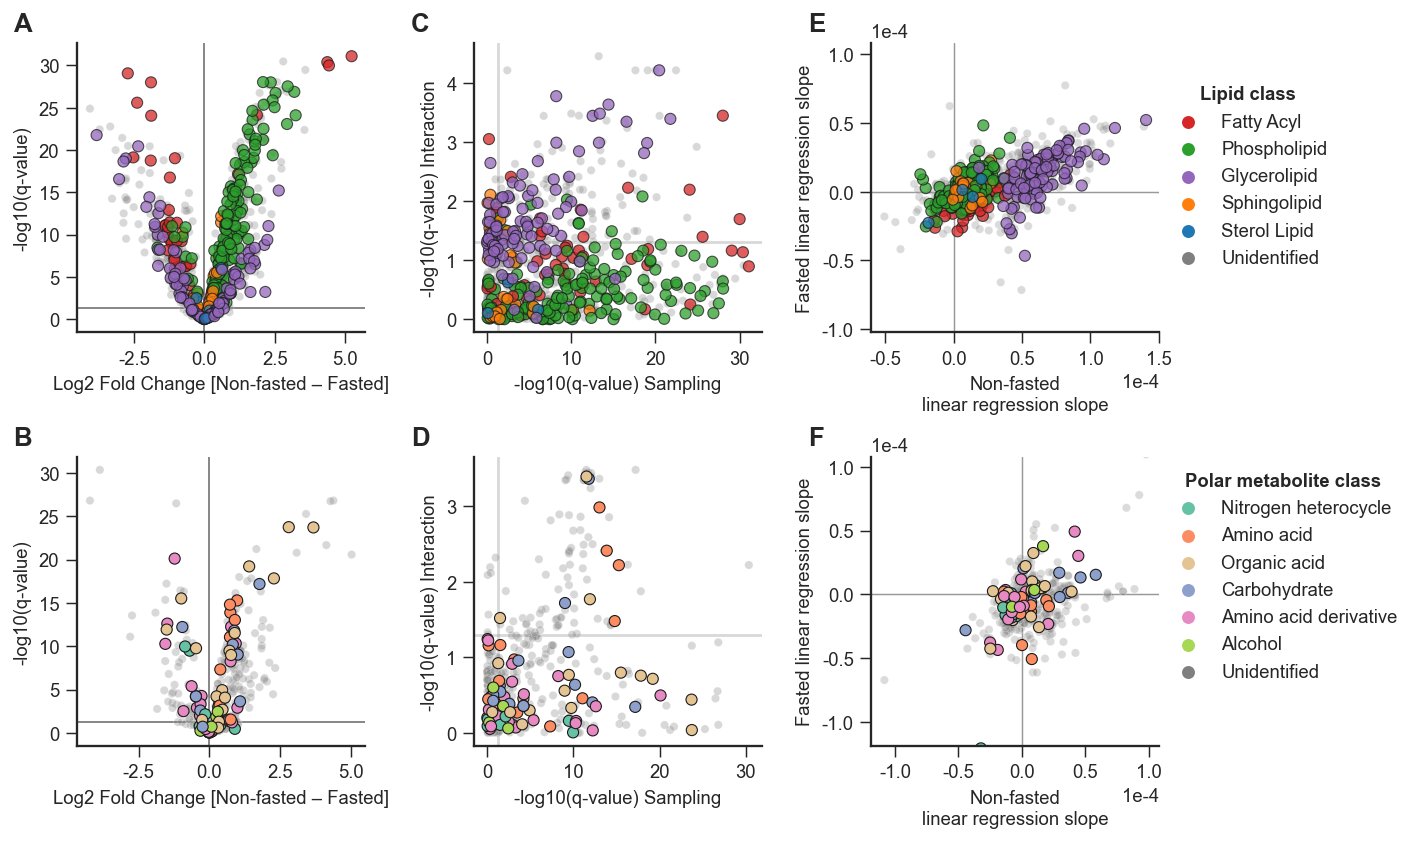

In [9]:
nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10.5, 7), dpi=133,
                        gridspec_kw={'hspace': 0.43, 'wspace': 0.38})

ax1 = axs[0][0]
ax2 = axs[1][0]
volcano(x='Log2 Fold Change', y='log_qval_sampling', df=fc, metab_type='lipid', ax=ax1, alpha=0.75)
volcano(x='Log2 Fold Change', y='log_qval_sampling', df=fc, metab_type='metabolite', ax=ax2, alpha=1)
ax1.set_xlabel('Log2 Fold Change [Non-fasted – Fasted]')
ax2.set_xlabel('Log2 Fold Change [Non-fasted – Fasted]')

# volcano(x='Log2 Fold Change', y='log_qval_sampling:ogtt', df=fc, metab_type='lipid', ax=axs[0][1], alpha=0.8)
# volcano(x='Log2 Fold Change', y='log_qval_sampling:ogtt', df=fc, metab_type='metabolite', ax=axs[1][1], alpha=1)

ax1 = axs[0][1]
ax2 = axs[1][1]
pvals_plot(x='log_qval_sampling', y='log_qval_sampling:ogtt', df=fc, metab_type='lipid', ax=ax1, alpha=0.75)
pvals_plot(x='log_qval_sampling', y='log_qval_sampling:ogtt', df=fc, metab_type='metabolite', ax=ax2, alpha=1)
ax1.set_xlabel('-log10(q-value) Sampling')
ax2.set_xlabel('-log10(q-value) Sampling')
ax1.set_ylabel('-log10(q-value) Interaction')
ax2.set_ylabel('-log10(q-value) Interaction')

ax1 = axs[0][2]
ax2 = axs[1][2]
fasted_fed_slope('lipid',      ax=ax1, alpha=0.75, legend=True)
fasted_fed_slope('metabolite', ax=ax2, alpha=1, legend=True)
ax1.legend(loc=(1.01, 0.2), title='Lipid class',  title_fontproperties={'weight':'bold'})
ax2.legend(loc=(1.01, 0.2), title='Polar metabolite class',  title_fontproperties={'weight':'bold'})
ax1.set_xlabel('Non-fasted\nlinear regression slope')
ax2.set_xlabel('Non-fasted\nlinear regression slope')

label = iter('ABCDEFGHIJ'[:nrows*ncols])
for col in range(ncols):
    for row in range(nrows):
        ax = axs[row][col]
        ax.text(s=next(label), x=-0.22, y=1.04, transform=ax.transAxes, fontsize=14, fontweight='bold')

# plt.savefig(r'../reports/figures/Figure_omics/volcano-pvalpval-slopeslope-plots.pdf', dpi=150, bbox_inches='tight')
# plt.savefig(r'../reports/figures/Figure_omics/volcano-pvalpval-slopeslope-plots.png', dpi=150, bbox_inches='tight')

# Volcano plots of molecule classes known to be important to diabetes
1. TG
2. PC
3. PE
4. LysoPC
5. LysoPE 
6. BCAAs

In [23]:
fc

,Log2 Fold Change,qval_sampling,qval_ogtt,qval_sampling:ogtt,superclass,coef_fasted,coef_fed,model_param_ogtt,Type,Fed - Fasted slope,signif_sampling,signif_interact,log_qval_sampling,log_qval_ogtt,log_qval_sampling:ogtt,is_id
i,,,,,,,,,,,,,,,,
m_0,0.277452,6.166626e-01,0.000123,0.807953,Unidentified,0.000078,0.000093,0.000078,metabolite,0.000015,False,False,0.209952,3.910703,0.092614,False
m_1,0.932597,1.019026e-12,0.000017,0.000577,Unidentified,0.000001,0.000037,0.000001,metabolite,0.000036,True,True,11.991815,4.758906,3.238921,False
m_2,-0.340412,1.781987e-01,0.583384,0.786415,Nitrogen heterocycle,-0.000002,-0.000010,-0.000002,metabolite,-0.000008,False,False,0.749096,0.234045,0.104348,True
m_3,-0.697301,3.269217e-10,0.128993,0.692485,Nitrogen heterocycle,-0.000009,-0.000004,-0.000009,metabolite,0.000004,True,False,9.485556,0.889435,0.159590,True
m_4,0.898423,3.473345e-01,0.056097,0.330235,Nitrogen heterocycle,-0.000121,-0.000032,-0.000121,metabolite,0.000089,False,False,0.459252,1.251058,0.481177,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_912,0.527198,1.274822e-02,0.001393,0.015366,Glycerolipid,0.000003,0.000051,0.000003,lipid,0.000049,True,True,1.894550,2.855954,1.813447,True
l_913,0.658842,5.508272e-02,0.253227,0.014866,Unidentified,-0.000025,0.000054,-0.000025,lipid,0.000079,False,True,1.258985,0.596491,1.827806,False
l_914,-1.419139,1.849586e-08,0.240940,0.008933,Unidentified,-0.000018,0.000038,-0.000018,lipid,0.000057,True,True,7.732926,0.618091,2.048989,False


In [68]:
fig.

In [ ]:
sns.FacetGrid

In [92]:
fig.get_axes()

[<AxesSubplot:title={'center':'molec_class = AC'}, ylabel='log_qval_sampling'>,
 <AxesSubplot:title={'center':'molec_class = Unidentified'}>,
 <AxesSubplot:title={'center':'molec_class = LysoPC'}>,
 <AxesSubplot:title={'center':'molec_class = LysoPE'}>,
 <AxesSubplot:title={'center':'molec_class = FA'}, ylabel='log_qval_sampling'>,
 <AxesSubplot:title={'center':'molec_class = PC'}>,
 <AxesSubplot:title={'center':'molec_class = Alkenyl-DG'}>,
 <AxesSubplot:title={'center':'molec_class = PI'}>,
 <AxesSubplot:title={'center':'molec_class = SM'}, ylabel='log_qval_sampling'>,
 <AxesSubplot:title={'center':'molec_class = Plasmenyl-PC'}>,
 <AxesSubplot:title={'center':'molec_class = Plasmanyl-PC'}>,
 <AxesSubplot:title={'center':'molec_class = Plasmenyl-PE'}>,
 <AxesSubplot:title={'center':'molec_class = PE'}, ylabel='log_qval_sampling'>,
 <AxesSubplot:title={'center':'molec_class = Plasmanyl-PE'}, xlabel='Log2 Fold Change'>,
 <AxesSubplot:title={'center':'molec_class = Cer[NS]'}, xlabel='Log

C:\Users\bjanderson23\anaconda3\lib\site-packages\seaborn\axisgrid.py:434: UserWarning: `gridspec_kws` ignored when using `col_wrap`
  warnings.warn("`gridspec_kws` ignored when using `col_wrap`")


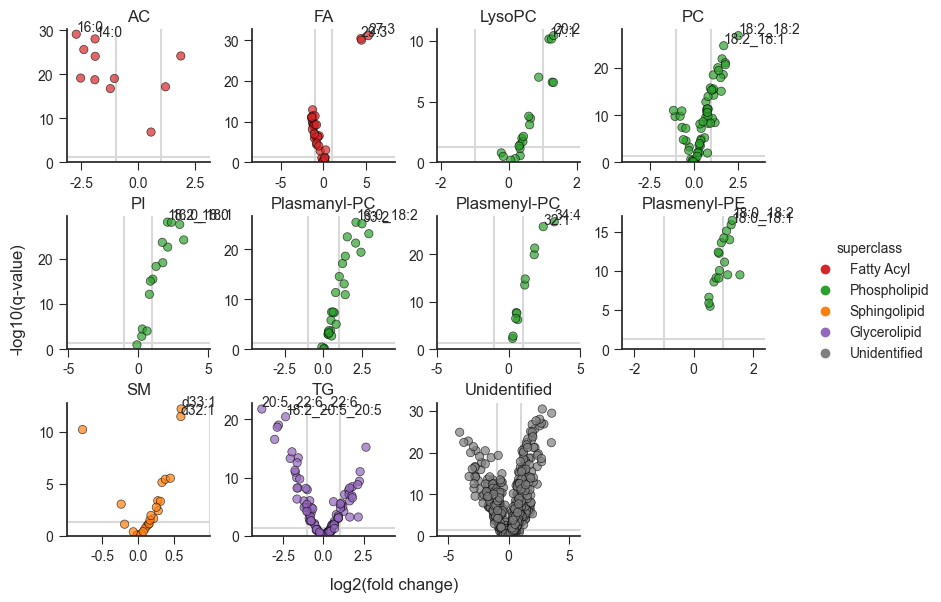

In [156]:
df = (data
    .loc[
        (data['molec_class'].map(data['molec_class'].value_counts()) > 10)
      & (data['Type'] == 'lipid') 
#     & (data['ID'] != 'Unidentified')
        ]
     .sort_values('molec_class'))

rp = sns.relplot(
    data=df,
    x='Log2 Fold Change', y='log_qval_sampling', hue='superclass', palette=colors,
    col='molec_class', 
    col_wrap=4,
    facet_kws=dict(
        sharey=False, 
        sharex=False,
#         legend_out=True,
        gridspec_kws=dict(hspace=0.15, wspace=0.01),
#         subplot_kws=dict(),
    ),
    linewidth=0.5, edgecolor='black', alpha=0.7,
)
fig = rp.fig
fig.set_size_inches(8, 6)
fig.set_dpi(100)
fig.legend(loc=(1.01, 0.3))
for ax, molec_class, letter in zip(fig.get_axes(), df['molec_class'].unique(), 'ABCDEFGHIJKLMNOPQRS'):
    maxlim = abs(max(ax.get_xlim()))
    ax.set(
        title=ax.get_title().lstrip('molec_class = '),
        xlim=(-1.5*maxlim, 1.5*maxlim),
        ylim=0,
        ylabel=None, 
        xlabel=None,
    )
    ax.axhline(-np.log10(0.05), color='0.85', zorder=-10)
    ax.axvline(1, color='0.85', zorder=-10)
    ax.axvline(-1, color='0.85', zorder=-10)
    
    if molec_class == 'Unidentified':
        continue
    mcdf = (df
            .loc[df['molec_class'] == molec_class]
            .sort_values('log_qval_sampling', ascending=False)
            .iloc[:2])
    for i, row in mcdf.iterrows():
        ax.annotate(text=row['ID'].lstrip(f'{molec_class} ').lstrip('O-'), 
                    xy=(row['Log2 Fold Change'], row['log_qval_sampling']), va='bottom', annotation_clip=False)
    
#     bb = tight_bbox(ax)
#     ax.text(x=bb.x0+0.1, y=bb.y1-0.03, s=letter, transform=ax.transAxes, fontweight='bold')

fig.supylabel('-log10(q-value)')
fig.supxlabel('log2(fold change)')

plt.tight_layout()

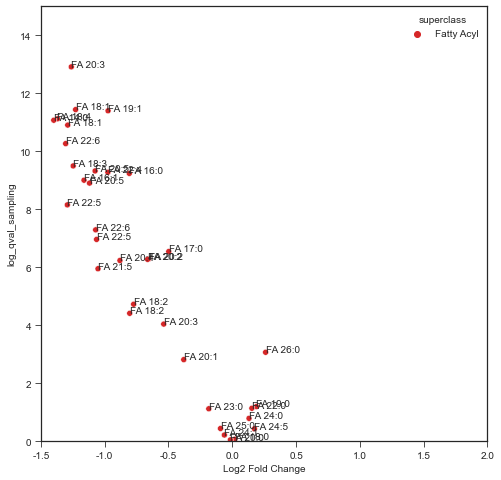

In [56]:
df = data.loc[(data['molec_class'] == 'FA')]
sns.scatterplot(
    data=df,
    x='Log2 Fold Change', y='log_qval_sampling', hue='superclass', palette=colors,
)

for i, row in df.iterrows():
    plt.annotate(xy=(row['Log2 Fold Change'], row['log_qval_sampling']), text=row['ID'])
    
plt.xlim(-1.5, 2)
plt.ylim(0, 15)
plt.gcf().set_size_inches(8, 8)

In [46]:
for (molec_class, _type), count in data[['molec_class', 'Type']].value_counts().iteritems():
#     print(molec_class)
    if molec_class == 'FA':
        sns.scatterplot(
            data=data.loc[(data['molec_class'] == molec_class) & (data['Type'] == _type)],
            x='Log2 Fold Change', y='log_qval_sampling', hue='superclass', palette=colors, ax=ax,
        )
        ax.set_title(f'{molec_class}')
    

In [47]:
data['molec_class'].unique()

array(['Unidentified', 'Nitrogen heterocycle', 'Amino acid',
       'Organic acid', 'Carbohydrate', 'Amino acid derivative', 'Alcohol',
       'AC', 'LysoPC', 'LysoPE', 'FA', 'PC', 'Alkenyl-DG', 'PI', 'SM',
       'Plasmenyl-PC', 'Plasmanyl-PC', 'Plasmenyl-PE', 'PE',
       'Plasmanyl-PE', 'Cer[NS]', 'TG', 'CE'], dtype=object)

In [72]:
# fig, ax = volcano(x='Fed - Fasted slope', y='qval_sampling:ogtt', df=fc, metab_type='lipid')
# ax.set_title('Sampling-OGTT glucose AUC Interaction')
# ax.set_xlabel('Non-fasted - Fasted slope')

In [73]:
# volcano(x='Fed - Fasted slope', y='qval_sampling:ogtt', df=fc, metab_type='metabolite', alpha=1)

# p-value vs. p-value plots

In [75]:
# relplot = sns.relplot(
#     data=fc.loc[fc['is_id']], x='log_qval_sampling', y='log_qval_sampling:ogtt', hue='superclass', palette=colors,
#     col='Type', 
# )
# fig = relplot.fig
# # legend = relplot.legend
# # legend = fig.axes[0].get_legend()
# legend = fig.legend()
# # legend(loc=(1.01, 0.5))
# # legend.(loc=(0.5, 0.5), )
# fig.set_size_inches((7, 4))
# fig.set_dpi(120)
# sns.despine()

Text(0, 0.5, '-log10(q-value interaction)')

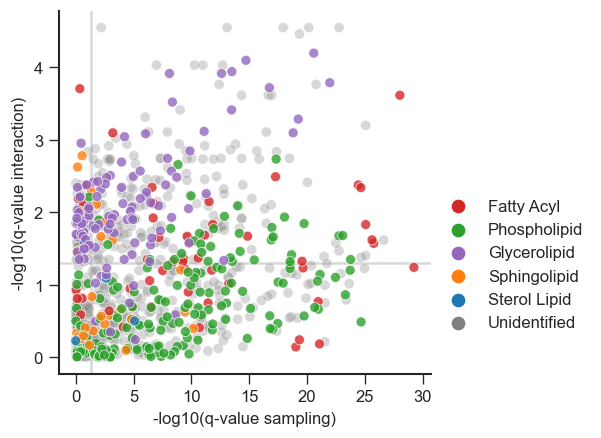

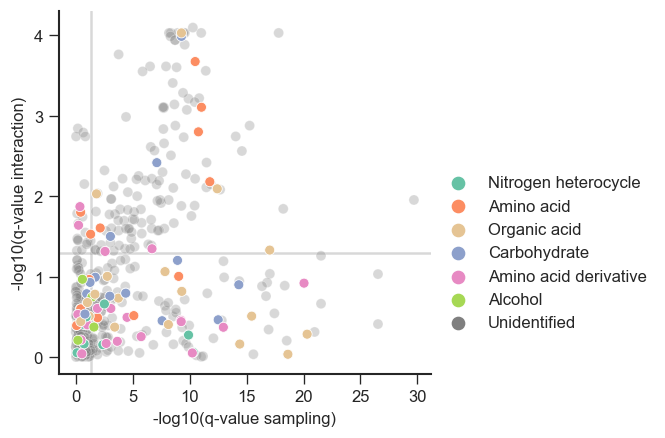

In [77]:
pval_pval_plot(x='log_qval_sampling', y='log_qval_sampling:ogtt', df=fc, _type='lipid')
ax = plt.gca()
ax.set_xlabel('-log10(q-value sampling)')
ax.set_ylabel('-log10(q-value interaction)')

pval_pval_plot(x='log_qval_sampling', y='log_qval_sampling:ogtt', df=fc, _type='metabolite', alpha=1)
ax = plt.gca()
ax.set_xlabel('-log10(q-value sampling)')
ax.set_ylabel('-log10(q-value interaction)')

pval_pval_plot(x='log_qval_ogtt', y='log_qval_sampling:ogtt', df=fc, _type='lipid')
ax = plt.gca()
ax.set_xlabel('-log10(q-value OGTT glucose AUC)')
ax.set_ylabel('-log10(q-value interaction)')

pval_pval_plot(x='log_qval_ogtt', y='log_qval_sampling:ogtt', df=fc, _type='metabolite')
ax = plt.gca()
ax.set_xlabel('-log10(q-value OGTT glucose AUC)')
ax.set_ylabel('-log10(q-value interaction)')

In [4]:
# df = data[data_cols].T.copy()
# df = (df
# #     .join(fg['bg_type'])
#     .groupby(fg['bg_type'])
#     .mean()
#      )
# # display(df)
# fc = ((df.loc['RBG'] - df.loc['FBG'])
#       .to_frame('Log2 Fold Change')
# #       .join(-np.log10(data[['qval_sampling', 'qval_ogtt', 'qval_sampling:ogtt']]))
#       .join(data[['qval_sampling', 'qval_ogtt', 'qval_sampling:ogtt', 
#                   'superclass', 'coef_fasted', 'coef_fed', 'model_param_ogtt', 'Type']])
#      )
# display(fc)
# fc['Fed - Fasted slope'] = fc['coef_fed'] - fc['coef_fasted']
# fc['signif_sampling'] = fc['qval_sampling'] < 0.05
# fc['signif_interact'] = fc['qval_sampling:ogtt'] < 0.05
# fc['log_qval_sampling'] = -np.log10(fc['qval_sampling'])
# fc['log_qval_ogtt'] = -np.log10(fc['qval_ogtt'])
# fc['log_qval_sampling:ogtt'] = -np.log10(fc['qval_sampling:ogtt'])
# fc['is_id'] = fc['superclass'] != 'Unidentified'
# fc

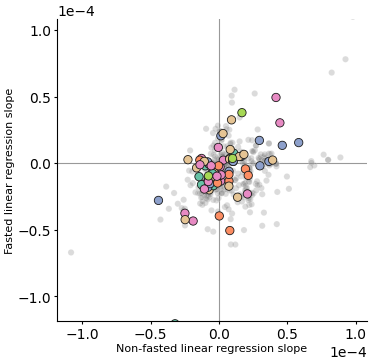

In [5]:
def fasted_fed_slope(_type, ax=None, alpha=0.8, legend=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,4), dpi=100)
    sns.scatterplot(
        data=data.loc[(data['superclass'] != 'Unidentified') & (data['Type'] == _type)],
        x='coef_fed', y='coef_fasted', hue='superclass', ax=ax, palette=colors, 
#         s=30, linewidth=0.5, edgecolor='gray',
        edgecolor='0.1', linewidth=0.6,
        alpha=alpha, legend=legend)
    sns.scatterplot(
        data=data.loc[(data['superclass'] == 'Unidentified') & (data['Type'] == _type)],
        x='coef_fed', y='coef_fasted', hue='superclass', ax=ax, palette=colors, s=20,
        alpha=0.28, zorder=-10, legend=legend)

    ###### 2 options for making sure the axes are equally scaled to not bias against non-fasted:
    ########## 1. ax.set_aspect('equal') enforces square, but distorts plot
    ########## 2. ylim average +/- 0.5 * xlim range 
    avg_ylim = np.mean([y for y in ax.get_ylim()])
    xlim_range = abs(ax.get_xlim()[0] - ax.get_xlim()[1])
    ax.set_ylim(avg_ylim-0.5*xlim_range, avg_ylim+0.5*xlim_range)
    ax.set_ylabel('Fasted linear regression slope')
    ax.set_xlabel('Non-fasted linear regression slope')
    ax.ticklabel_format(style='sci', scilimits=(-1, 1))
    ax.axvline(0, c='gray', linewidth=0.8, alpha=0.8, zorder=-99)
    ax.axhline(0, c='gray', linewidth=0.8, alpha=0.8, zorder=-99)
    if legend:
        ax.legend(loc=(0.8, 0.05), markerscale=1.2)
    sns.despine()

# fasted_fed_slope('lipid', alpha=0.8)
fasted_fed_slope('metabolite', alpha=1)

In [61]:
ap.loc[~ap['lcms_sampled']]

,Nile rat label,Date of birth,litter,lcms_sampled,glucose_tolerance,OGTT(0min),OGTT(10min),OGTT(20min),OGTT(30min),OGTT(60min),...,Weightprefastweek12,HbA1c,Interscapular brown fat (g),BF (%BW),Inguinal white fat one side (g),WF (%BW),BF/WF,Plasma,Fatty liver,Notes
animal,,,,,,,,,,,,,,,,,,,,,
1061,NaN,2021-01-23,0,False,NaN,48.0,196.5,344.5,449.5,518.0,...,101.7,NaN,1.7808,1.751032,0.6059,0.595772,2.939099,murky,Slight,NaN
1063,NaN,2021-01-23,0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,109.2,NaN,2.5485,2.333791,0.8614,0.788828,2.958556,NaN,No,OGTT failed Didn't collect tissue or post-OGTT...
1075,NaN,2021-01-23,0,False,NaN,169.0,355.0,600.0,600.0,569.5,...,105.5,NaN,1.3107,1.242370,0.5910,0.560190,2.217766,White,Yes,NaN
1080,NaN,2021-01-24,1,False,NaN,NaN,NaN,NaN,NaN,NaN,...,112.1,NaN,1.9369,1.727832,0.7754,0.691704,2.497937,NaN,No,OGTT failed Didn't collect tissue or post-OGTT...
1081,NaN,2021-01-24,1,False,NaN,171.0,345.0,547.0,600.0,563.0,...,113.2,NaN,1.3511,1.193551,0.6283,0.555035,2.150406,White,No,NaN
1094,NaN,2021-01-31,2,False,NaN,48.0,135.0,195.5,237.5,219.0,...,98.0,NaN,1.5393,1.570714,0.6410,0.654082,2.401404,clear,Slight,NaN
1095,NaN,2021-01-31,2,False,NaN,43.0,85.5,445.5,483.0,517.5,...,98.3,NaN,1.7470,1.777213,0.6412,0.652289,2.724579,clear,Very slight,OGTT (AUC): Animal stressed?
1096,NaN,2021-01-31,2,False,NaN,58.5,186.0,248.5,302.5,485.5,...,104.4,NaN,1.1691,1.119828,0.6014,0.576054,1.943964,clear,Slight,NaN
1100,NaN,2021-02-01,3,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,euthanized


In [64]:
ap[['OGTT (AUC)', 'lcms_sampled']]

,OGTT (AUC),lcms_sampled
animal,,
1060,48742.5,True
1061,46485.0,False
1062,43717.5,True
1063,NaN,False
1074,35250.0,True
1075,59782.5,False
1076,60245.0,True
1080,NaN,False
1081,59965.0,False
